In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.api import qqplot
from statsmodels.api import qqplot,add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
matplotlib.rc("font", family = "NanumGothic")
matplotlib.rc("axes", unicode_minus = False)

## 데이터 구성

In [2]:
df_raw = pd.read_csv("/home/piai/강의자료/Datahandling/BigData기초/체질검사.csv", encoding = 'euc-kr')
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER
0,35.2,46,363.15 lb,72.25 inch,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,남성
1,11.8,27,168 lb,71.25 inch,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,남성
2,22.2,69,177.75 lb,68.5 inch,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,남성
3,10.6,57,147.75 lb,65.75 inch,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,여성
4,47.5,51,219 lb,64 inch,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,여성


In [3]:
df_raw.isnull().sum()

FAT        0
AGE        0
WEIGHT     0
HEIGHT     0
NECK       0
CHEST      0
ABDOMEN    0
HIP        0
THIGH      0
KNEE       0
ANKLE      0
BICEPS     0
FOREARM    0
WRIST      0
GENDER     0
dtype: int64

In [4]:
df_raw[['WEIGHT','WEIGHT_UNIT']] = df_raw["WEIGHT"].str.split(expand=True)
df_raw[['HEIGHT','HEIGHT_UNIT']] = df_raw["HEIGHT"].str.split(expand=True)
df_raw["WEIGHT"] = df_raw["WEIGHT"].astype('float64')
df_raw["HEIGHT"] = df_raw["HEIGHT"].astype('float64')

df_raw = df_raw.drop(['WEIGHT_UNIT','HEIGHT_UNIT'],axis= 1)

df_raw_dummy = pd.get_dummies(df_raw, drop_first = True)
df_raw_dummy.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1


### 단위와 같이 표현되어 있는 수치형 변수 처리

### 단위를 나타내는 항목 제외

### 범주형 Dummy 변수화

In [5]:
df_raw_dummy["BMI"] = ((df_raw_dummy["WEIGHT"] * 0.45) / ((df_raw_dummy["HEIGHT"] / 100 * 2.54) ** 2)).round(2)
df_raw_dummy.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0,48.52
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0,23.08
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0,26.42
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1,23.84
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1,37.29


BMI 계산 시, WEIGHT 단위는 pound(1lb = 0.45kg), HEIGHT 단위는 inch(1inch = 2.54cm)이므로 변환하여 사용할 것

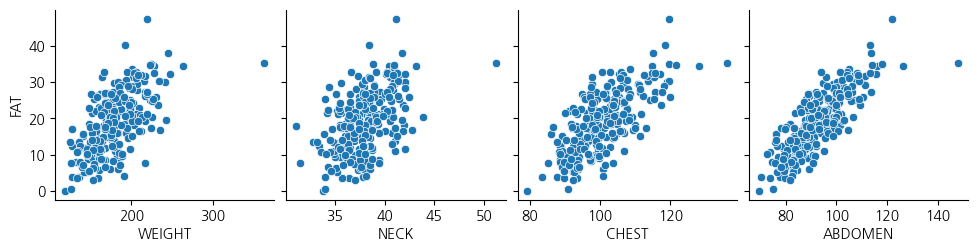

In [6]:
sns.pairplot(df_raw_dummy, y_vars = "FAT",x_vars = ["WEIGHT","NECK","CHEST","ABDOMEN"])

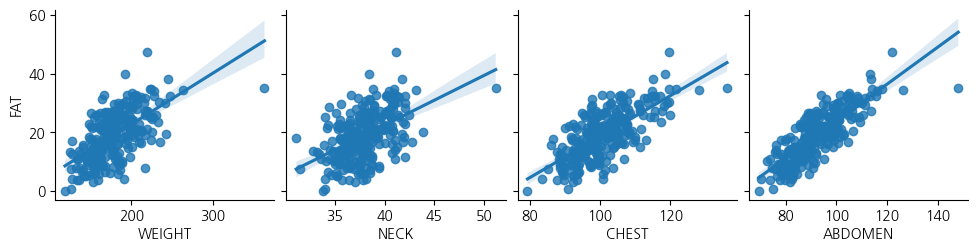

In [7]:
sns.pairplot(df_raw_dummy, y_vars = "FAT",x_vars = ["WEIGHT","NECK","CHEST","ABDOMEN"],kind="reg")

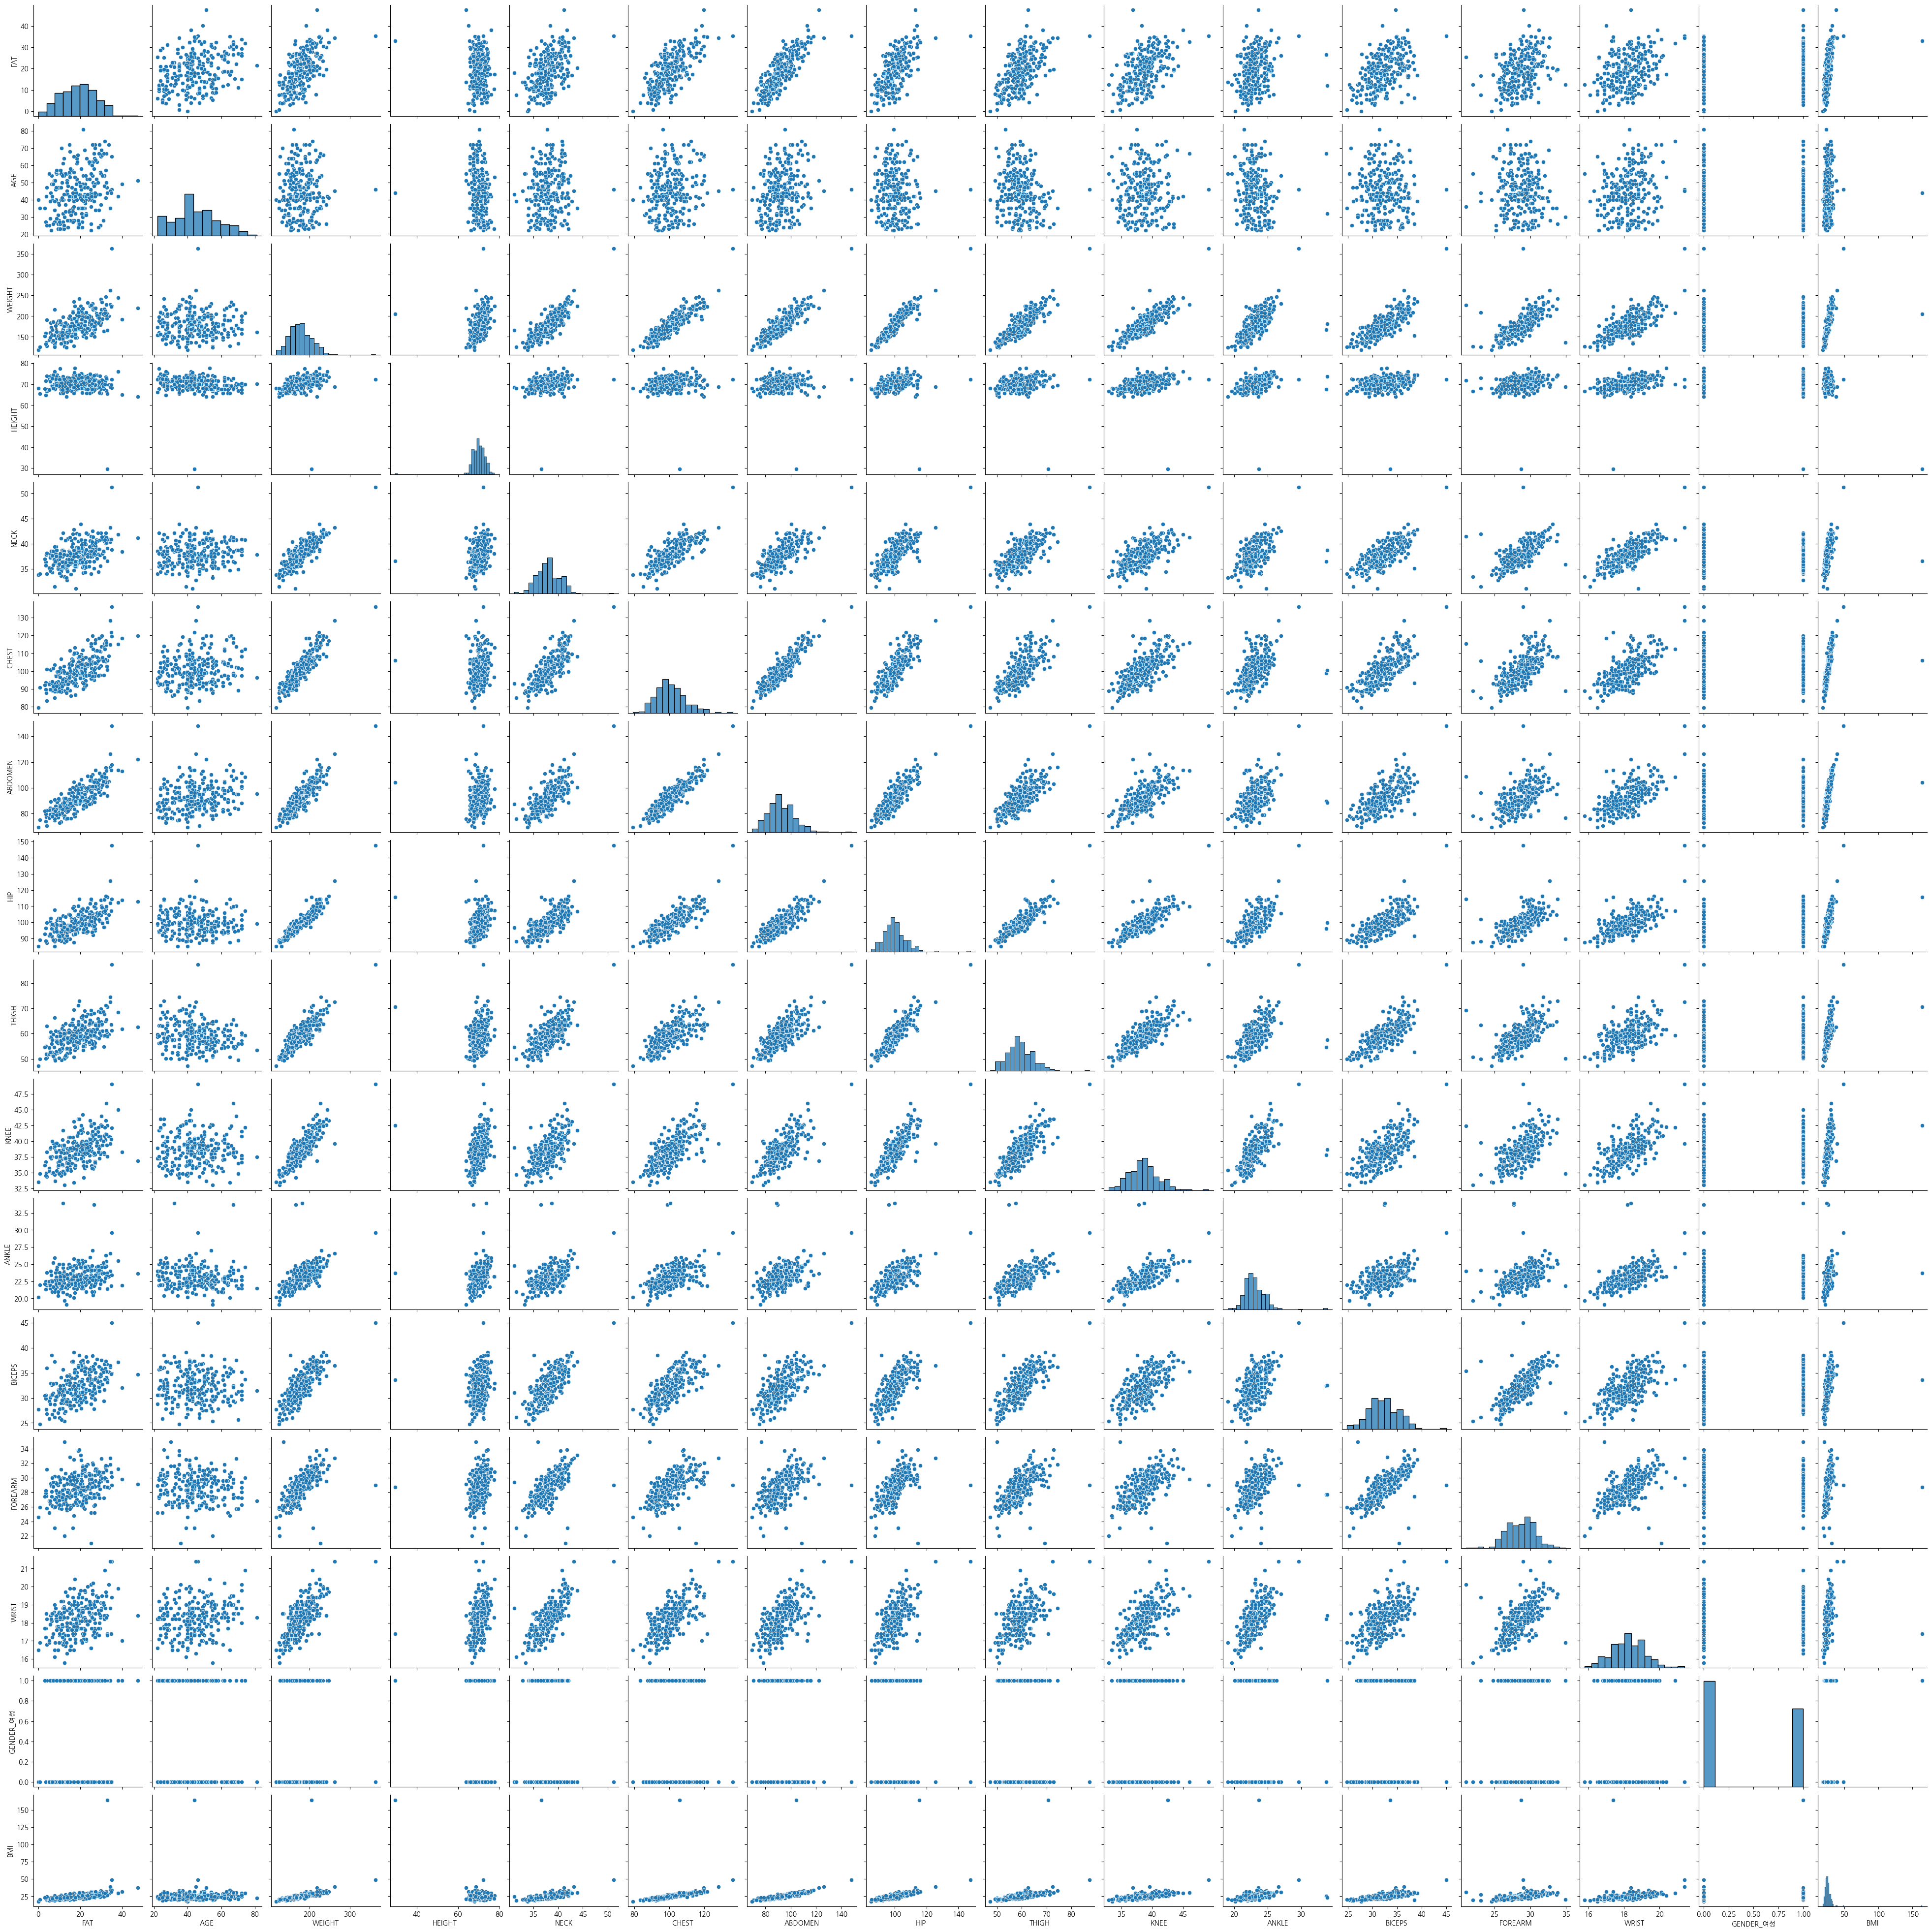

In [8]:
sns.pairplot(df_raw_dummy)

## 변수 간의 경향성 파악(상관관계 분석)

In [9]:
df_raw_dummy.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성,BMI
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347,-0.033,0.371
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214,-0.063,0.040
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730,-0.009,0.391
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322,0.025,-0.638
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745,0.010,0.266
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660,-0.014,0.383
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620,-0.017,0.415
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630,-0.042,0.462
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559,-0.040,0.433
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665,-0.034,0.364


### 목표 변수 FAT과 ABDOMEN(0.813) CHEST(0.703) 순서로 높은 선형관계 확인.

In [10]:
df_train, df_test = train_test_split(df_raw_dummy, test_size = 0.4, random_state = 5678)
print("train dzta size : {}".format(df_train.shape))
print("test dzta size : {}".format(df_test.shape))

train dzta size : (151, 16)
test dzta size : (101, 16)


### 데이터는 (train(0.6) : test(0.4) )의 비율로 분할 (train_test_split 활용)

In [11]:
reg_model = smf.ols(formula='FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                             KNEE + ANKLE + BICEPS + FOREARM + WRIST + GENDER_여성 + BMI', data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     29.08
Date:                Mon, 15 May 2023   Prob (F-statistic):           5.45e-35
Time:                        19:47:12   Log-Likelihood:                -427.01
No. Observations:                 151   AIC:                             886.0
Df Residuals:                     135   BIC:                             934.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.1454     36.085     -0.475      0.6

### 회귀 모델 생성 및 설명변수 간의 다중공선성 확인

In [12]:
df_train_x = df_train.drop('FAT',axis = 1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values,i)\
                for i in range(df_train_x_const.shape[1])]

df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
14,GENDER_여성,1.08
10,ANKLE,2.21
1,AGE,2.58
11,BICEPS,3.46
12,FOREARM,3.68
13,WRIST,4.16
4,NECK,4.78
9,KNEE,4.82
8,THIGH,7.41
5,CHEST,12.80


### WEIGHT의 VIF가 65.13으로 높게 나타난다. -> 모델에서 제외

In [19]:
reg_model = smf.ols(formula='FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                             KNEE + ANKLE + BICEPS + FOREARM + WRIST + GENDER_여성 + BMI', data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     31.30
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.10e-35
Time:                        19:49:04   Log-Likelihood:                -427.17
No. Observations:                 151   AIC:                             884.3
Df Residuals:                     136   BIC:                             929.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2908     11.644      0.111      0.9

### P-value가 0.05 이상 변수(HIP, KNEE 등) 제거

In [25]:
df_train_x = df_train.drop(['FAT',"WEIGHT"],axis =1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values,i)\
                for i in range(df_train_x_const.shape[1])]

df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
13,GENDER_여성,1.07
9,ANKLE,2.20
1,AGE,2.47
10,BICEPS,3.38
11,FOREARM,3.60
12,WRIST,3.96
3,NECK,4.29
8,KNEE,4.78
2,HEIGHT,6.71
14,BMI,6.97


### ABDOMEN VIF는 11.32로 다중공선성이 의심되지만, 목표변수에 영향이 큰 변수이므로 제거 X

In [29]:
reg_model = smf.ols(formula = 'FAT ~ NECK + ABDOMEN + WRIST', data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     142.1
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.99e-43
Time:                        20:02:05   Log-Likelihood:                -433.15
No. Observations:                 151   AIC:                             874.3
Df Residuals:                     147   BIC:                             886.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.0443      7.136     -1.127      0.2

In [32]:
df_train_x = df_train[["NECK","ABDOMEN","WRIST"]]
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values,i)\
                for i in range(df_train_x_const.shape[1])]

df_vif.sort_values("VIF",inplace=True)
df_vif.round(2)

,variable,VIF
2,ABDOMEN,2.18
3,WRIST,2.51
1,NECK,3.32
0,const,412.23


### VIF가 10 미만이므로, 다중공선성 해결.

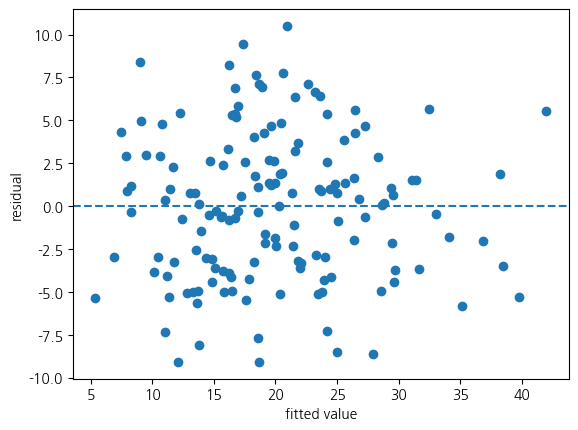

In [33]:
plt.scatter(reg_result.fittedvalues,reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0,linestyle="--")

잔차가 y = 0을 기준으로 랜덤하게 산포되어 있으므로 등분산성을 만족.

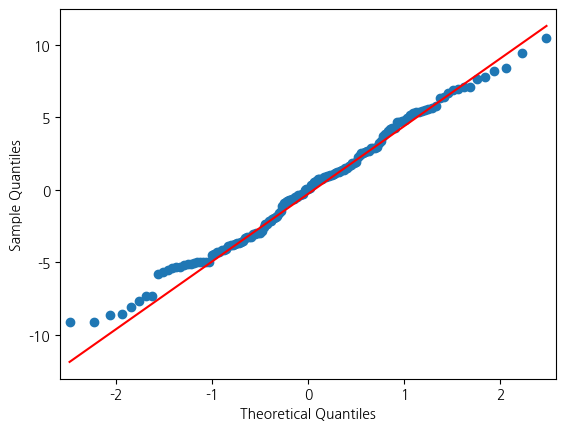

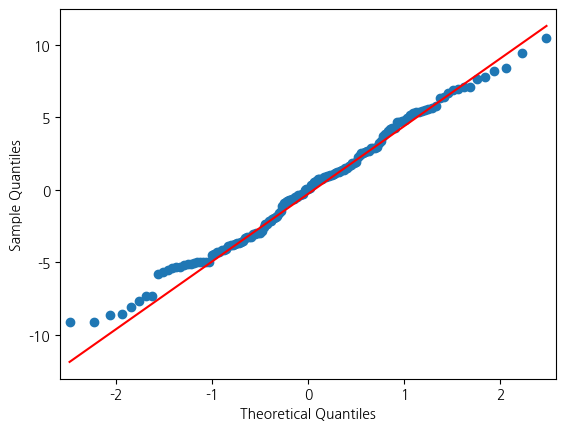

In [34]:
qqplot(reg_result.resid,line="q")

정규뷴포 직선을 중심으로 분포하므로 정규분포를 따름.

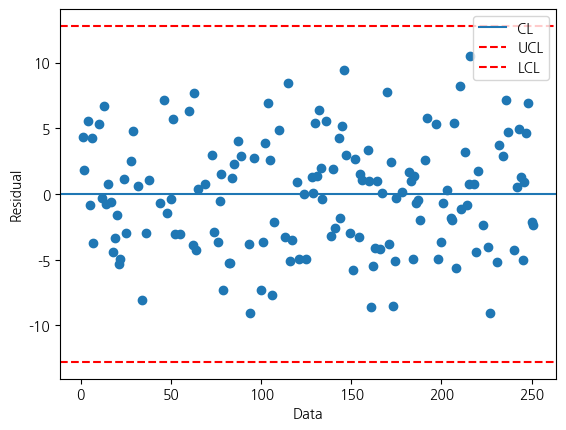

In [35]:
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data")
plt.ylabel("Residual")
plt.axhline(y=0,linestyle="-",label="CL")
plt.axhline(y=3*np.std(reg_result.resid),linestyle="--",color="red",label="UCL")
plt.axhline(y=-3*np.std(reg_result.resid),linestyle="dashed",color="red",label="LCL")
plt.legend()

잔차가 y = 0을 기준으로 관리상하한을 벗어나지 않고, 랜덤하게 산포되어 있으므로 독립성을 만족시킨다.

In [36]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수: ",r2_score(df_train["FAT"],train_pred))
print("test data의 결정계수: ",r2_score(df_test["FAT"],test_pred))

train data의 결정계수:  0.7436291989053558
test data의 결정계수:  0.6398167848558076


train data의 결정계수 : 74.3%

test data의 결정계수 : 63.9%